# Predicting Health Insurance

---

## Importing Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, make_scorer
from imblearn.over_sampling import SMOTE
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [46]:
custom_palette = ['#63783D', '#CFE0BC']
sns.set_palette(custom_palette)

---

## Loading Data

In [47]:
df = pd.read_csv('../data/customer.csv')

df.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


---

## Data Exploration

In [48]:
df.shape

(72458, 15)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


In [50]:
df.describe()

,Unnamed: 0,income,num_vehicles,age,code_column,gas_usage,rooms
count,72458.000000,7.245800e+04,70772.000000,72458.000000,72458.000000,70772.000000,72458.000000
mean,49910.637556,4.188143e+04,2.066820,49.208893,3285.523572,41.230501,3.494549
std,28772.082702,5.827460e+04,1.170076,18.090035,2661.775225,63.149323,1.706537
min,7.000000,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000
25%,24911.250000,1.070000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000
50%,49838.000000,2.640000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000
75%,74786.750000,5.200000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000
max,100000.000000,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000


In [51]:
print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
Unnamed: 0            0
custid                0
sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64


In [52]:
print("\nDuplicate rows:", df.duplicated().sum())


Duplicate rows: 0


In [53]:
print("\nUnique values per column:", df.nunique())


Unique values per column: Unnamed: 0        72458
custid            72458
sex                   2
is_employed           2
income             4445
marital_status        4
health_ins            2
housing_type          4
num_vehicles          7
age                  81
state_of_res         51
code_column          49
gas_usage            57
rooms                 6
recent_move_b         2
dtype: int64


---

## Data Preprocessing

# Brief Analysis of the Columns

## Unnecessary Columns:

- `Unnamed: 0` - This column functions as an index, so it is irrelevant and can be removed.

- `custid` - The ID of each customer is also unnecessary for the analysis and will be removed as well.

- `code_column` - The column containing the code is likewise irrelevant.

## Necessary Columns:

- The columns: `sex`, `is_employed`, `income`, `marital_status`, **`health_ins`**, `housing_type`, `num_vehicles`, `age`, `state_of_res`, `gas_usage`, `rooms`, and `recent_move_b` are all relevant for predicting the primary variable **`health_ins`**.


### Drop unnecessary columns

In [54]:
df = df.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b
0,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,210.0,3,F
1,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,3.0,6,T
2,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,40.0,3,F
3,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,120.0,2,F
4,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,3.0,2,F


### Handling missing values

#### In is_employed column

Estes valores não são considerados missing values, pois como vem explicado no **Data dictionary** são pessoas consideradas `not in workforce` daí nos trocamos os valores de NaN's para 'Not in Workforce' 

In [55]:
df['is_employed'] = df['is_employed'].fillna('Not in Workforce')

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b
0,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,210.0,3,F
1,Female,Not in Workforce,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,3.0,6,T
2,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,40.0,3,F
3,Female,Not in Workforce,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,120.0,2,F
4,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,3.0,2,F


#### In the rest of the columns

In [56]:
missing_housing = df['housing_type'].isnull()
missing_vehicles = df['num_vehicles'].isnull()
missing_gas = df['gas_usage'].isnull()
missing_recent_move = df['recent_move_b'].isnull()

print("Total missing in housing_type:", missing_housing.sum())
print("Total missing in num_vehicles:", missing_vehicles.sum())
print("Total missing in gas_usage:", missing_gas.sum())
print("Total missing in recent_move_b:", missing_recent_move.sum())

Total missing in housing_type: 1686
Total missing in num_vehicles: 1686
Total missing in gas_usage: 1686
Total missing in recent_move_b: 1687


We noticed that only `recent_move_b` has one more NaN than the other three columns. Therefore, we can check if the other three columns share the same NaN values, and if they do, we can remove these rows, as they represent a minimal percentage of the dataset, only **2.3% of the dataset**.
This approach ensures data quality while retaining 97.7% of the data for analysis and modeling.

In [57]:
nan_rows = df[(df['housing_type'].isna()) & 
              (df['num_vehicles'].isna()) & 
              (df['gas_usage'].isna())]

same_nan_count = nan_rows.shape[0]
print(f"Number of rows with simultaneous NaNs: {same_nan_count}")

Number of rows with simultaneous NaNs: 1686


In [ ]:
# moda
df['housing_type'] = df['housing_type'].fillna(df['housing_type'].mode()[0])

# mmédia ARREDONDADA ÀS UNIDADES
df['num_vehicles'] = df['num_vehicles'].fillna(df['num_vehicles'].mean())

# no gas_usage: 
# se for NA (unknown or not applicable) mete a média
# se for 001 (Included in rent or in condo fee) mete 0
# se for 002 (Included in electricity payment) mete 0
# se for 003 (No charge or gas not used) mete 0
df['gas_usage'] = df['gas_usage'].fillna(df['gas_usage'].mean())
df['gas_usage'] = df['gas_usage'].replace('001', 0)
df['gas_usage'] = df['gas_usage'].replace('002', 0)
df['gas_usage'] = df['gas_usage'].replace('003', 0)

# moda
df['recent_move_b'] = df['recent_move_b'].fillna(df['recent_move_b'].mode()[0])

# média para os Unkonwn's
df['age'] = df['age'].fillna(df['age'].mean())

print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
sex                  0
is_employed          0
income               0
marital_status       0
health_ins           0
housing_type         0
num_vehicles      1686
age                  0
state_of_res         0
gas_usage            0
rooms                0
recent_move_b        0
dtype: int64


### Handling outliers

In [59]:
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms']

#### Detecting outliers

##### Distribution plots 

This section visualizes the distribution of numerical features to observe their overall shape and detect potential skewness or outliers. Features with a strong skew might require transformations before modeling.

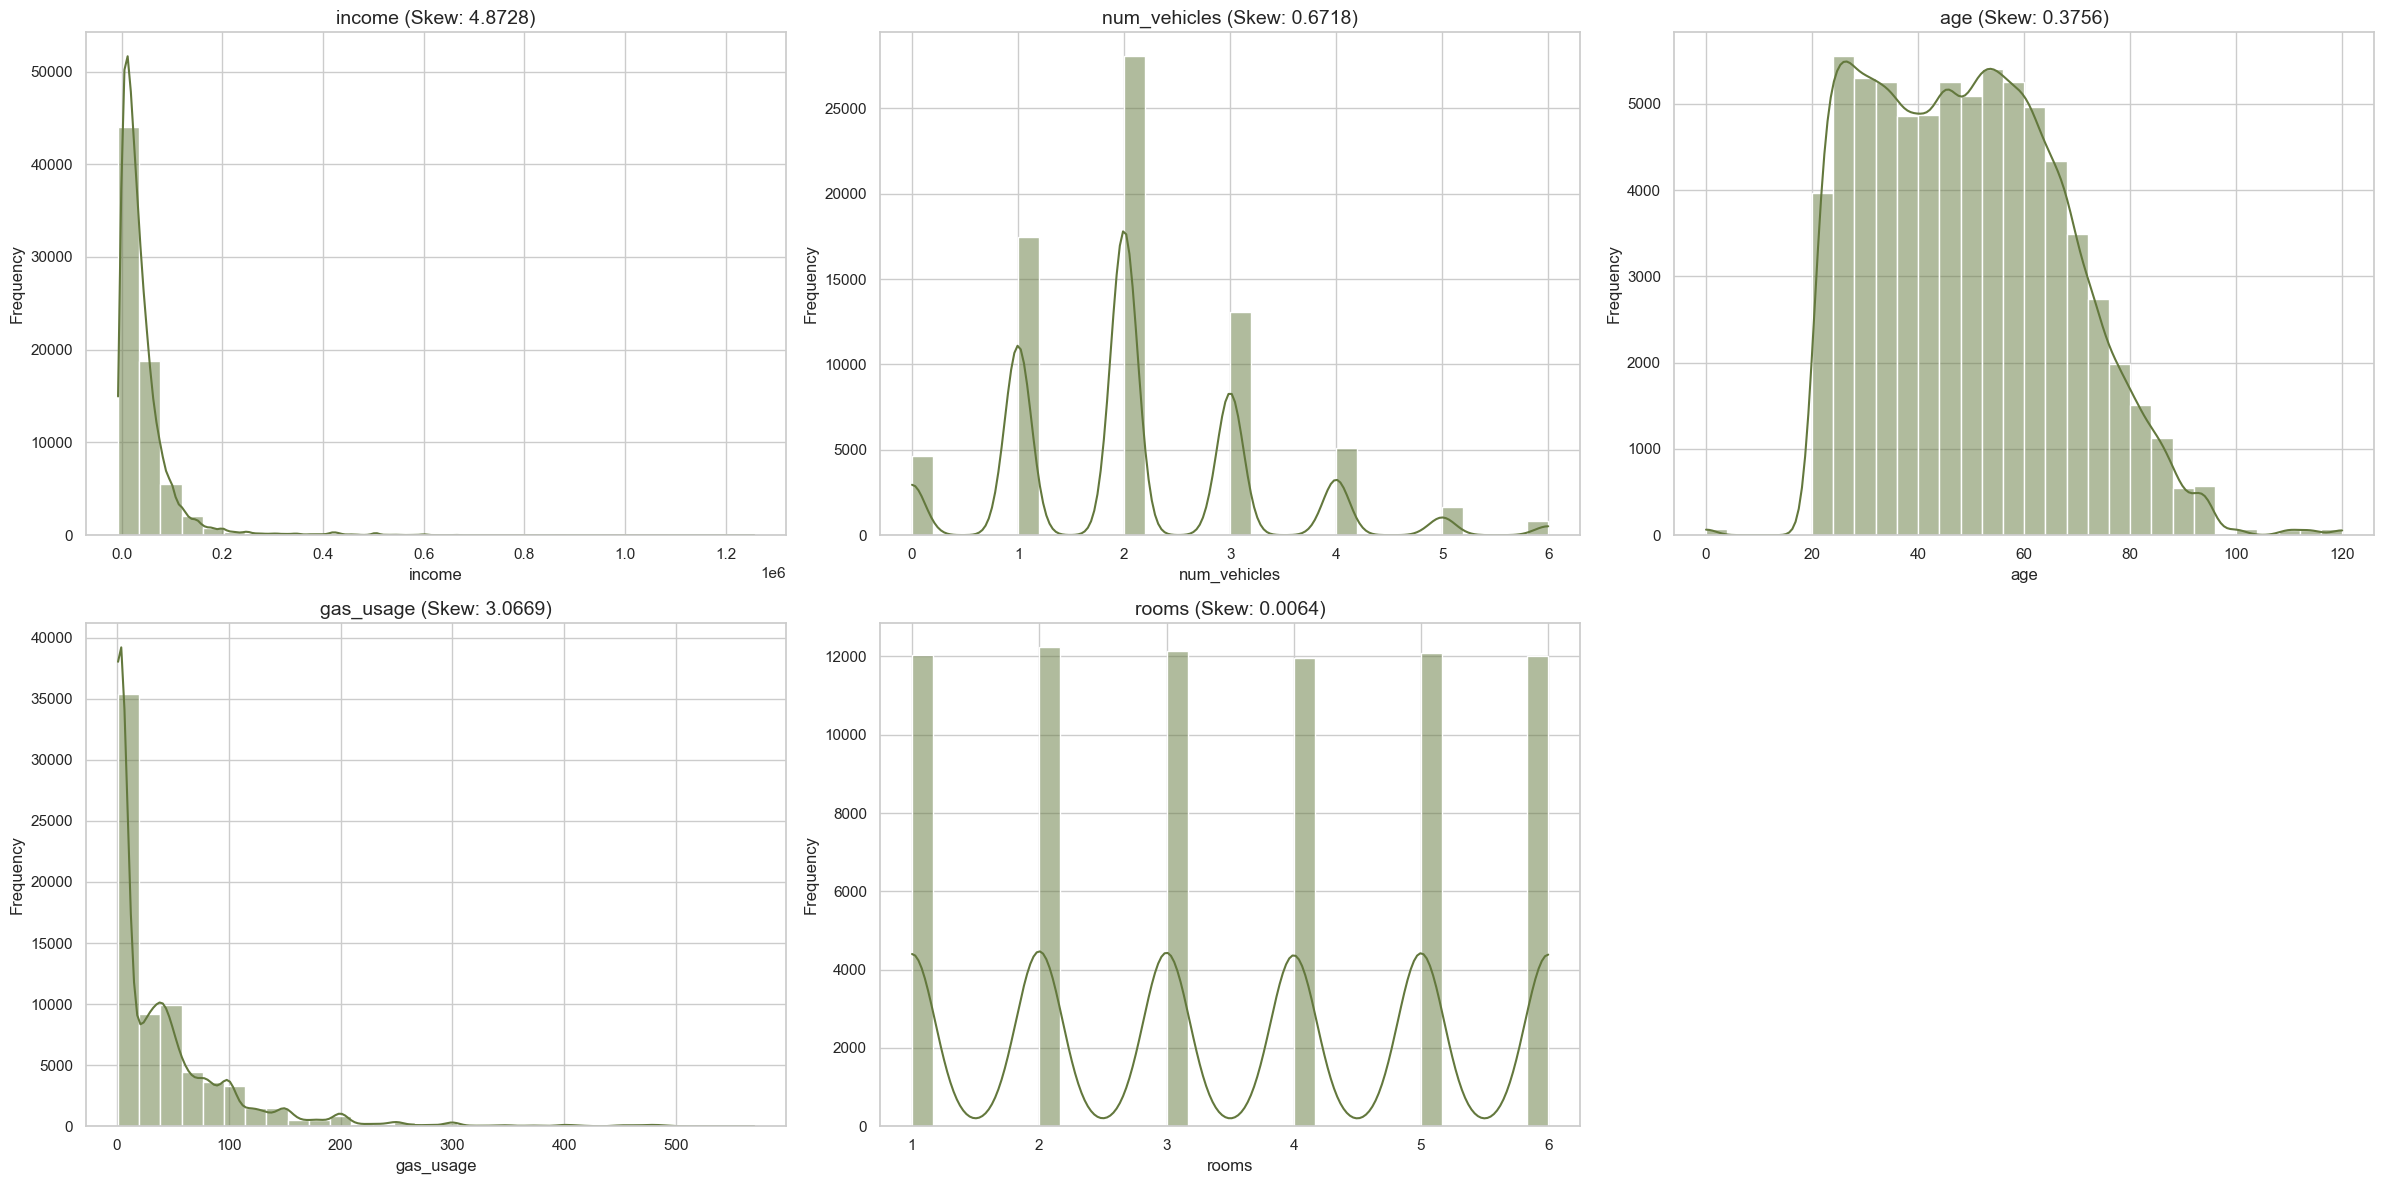

In [60]:
color = custom_palette[0]

f, axes = plt.subplots(2, 3, figsize=(24, 12)) 
axes = axes.flatten()

for i, col in enumerate(df[numerical_features].columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color=color)
    axes[i].set_title(f'{col} (Skew: {df[col].skew():.4f})', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

##### Box Plots

Boxplots visually represent the spread of data and highlight potential outliers as points outside the whiskers.

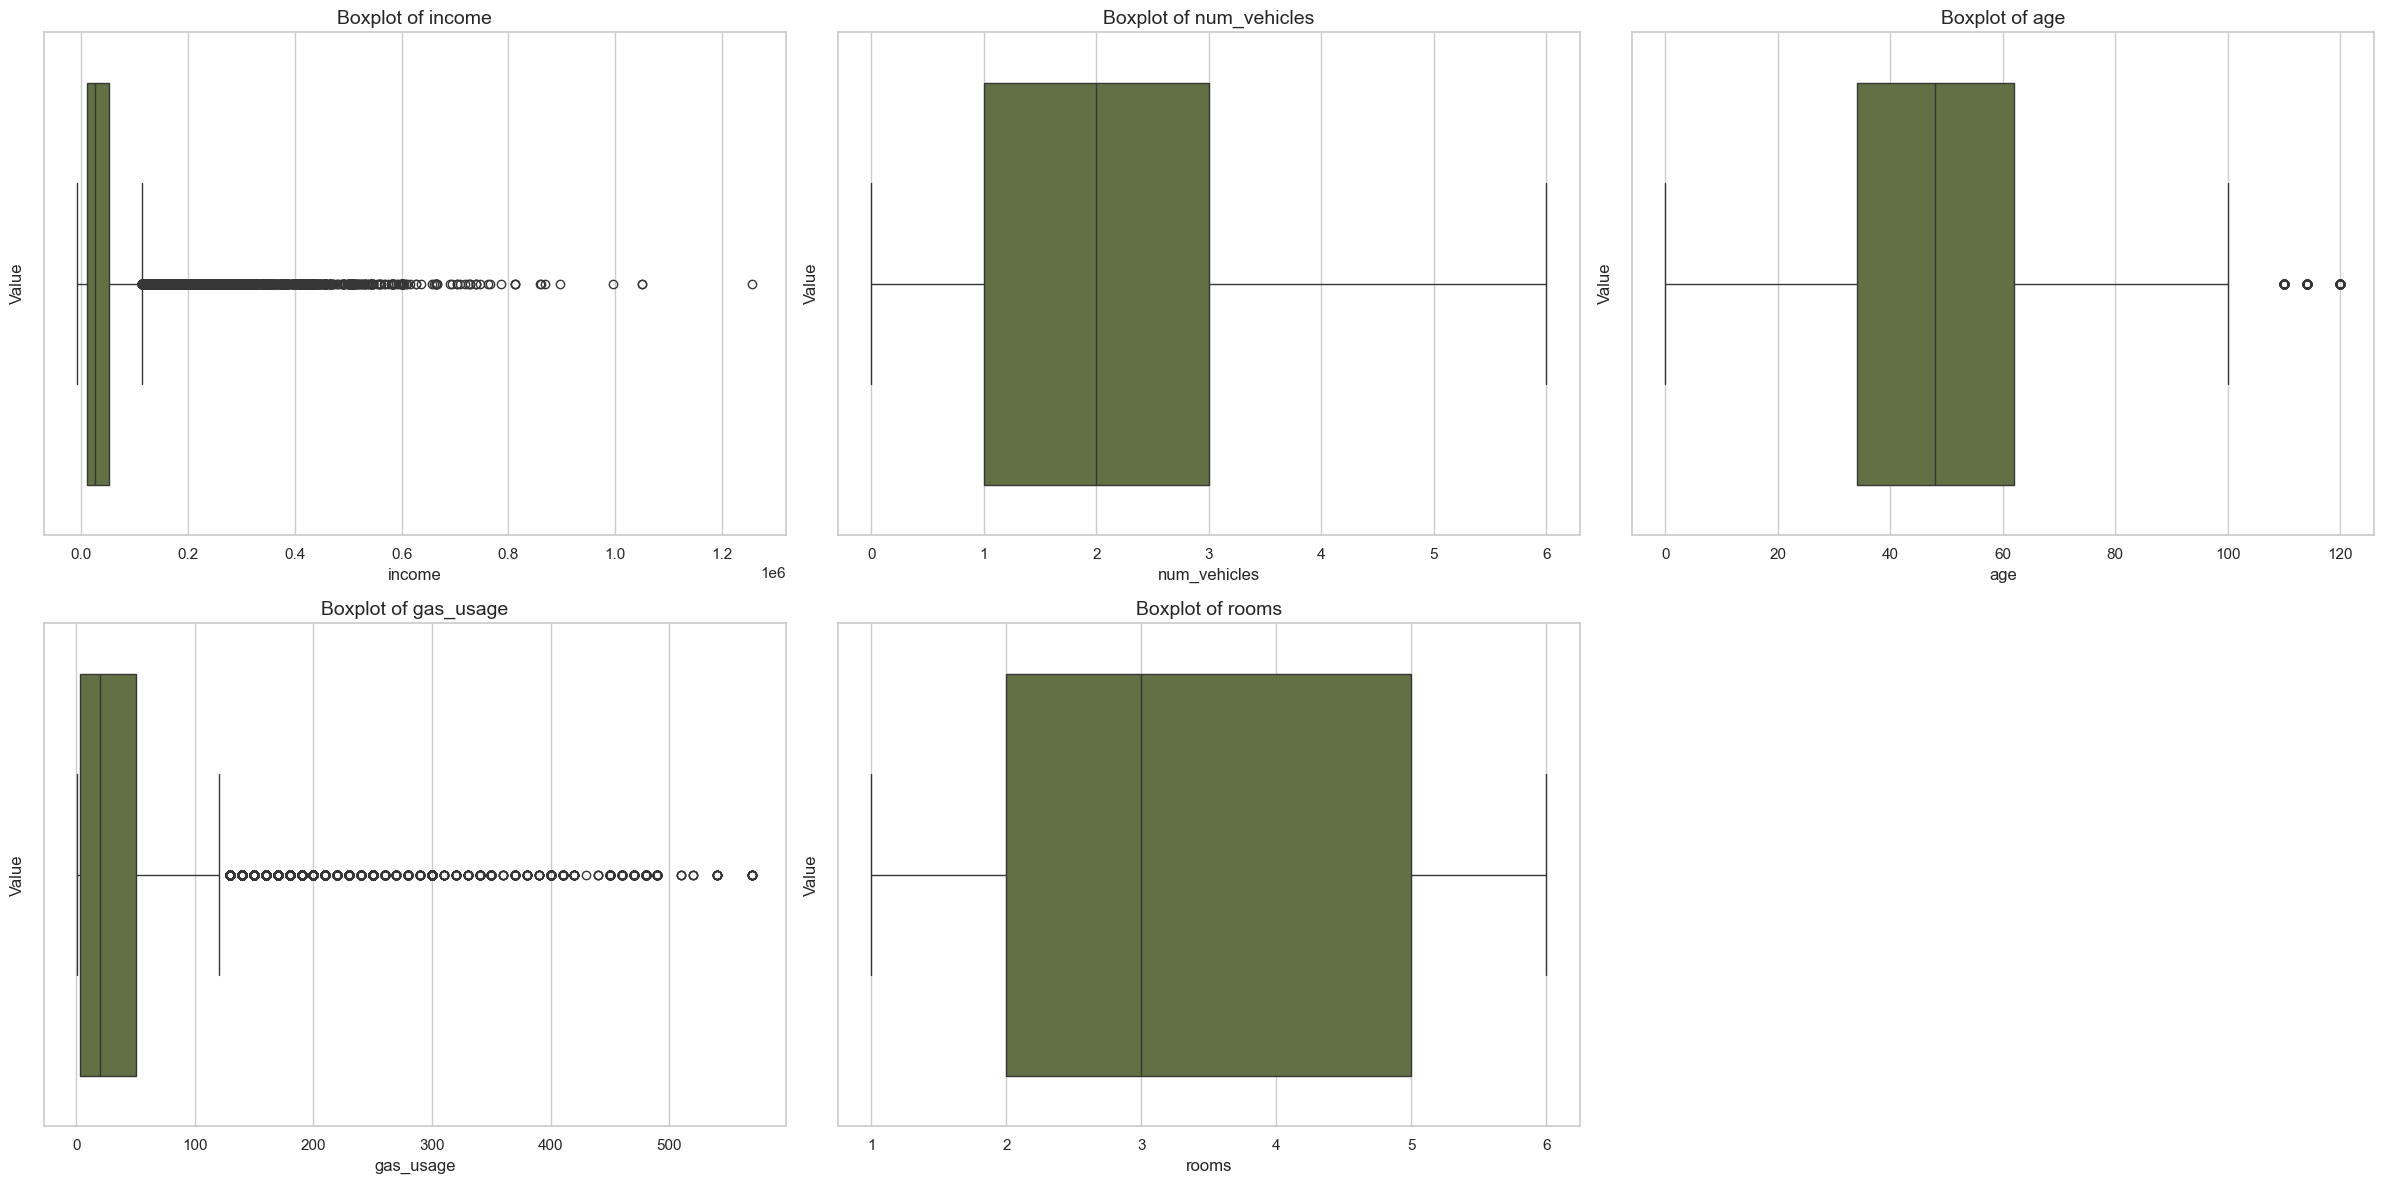

In [61]:
sns.set_theme(style="whitegrid")

f, axes = plt.subplots(2, 3, figsize=(24, 12))  
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i], color=color)
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Value', fontsize=12)

for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


##### Scatter Plots

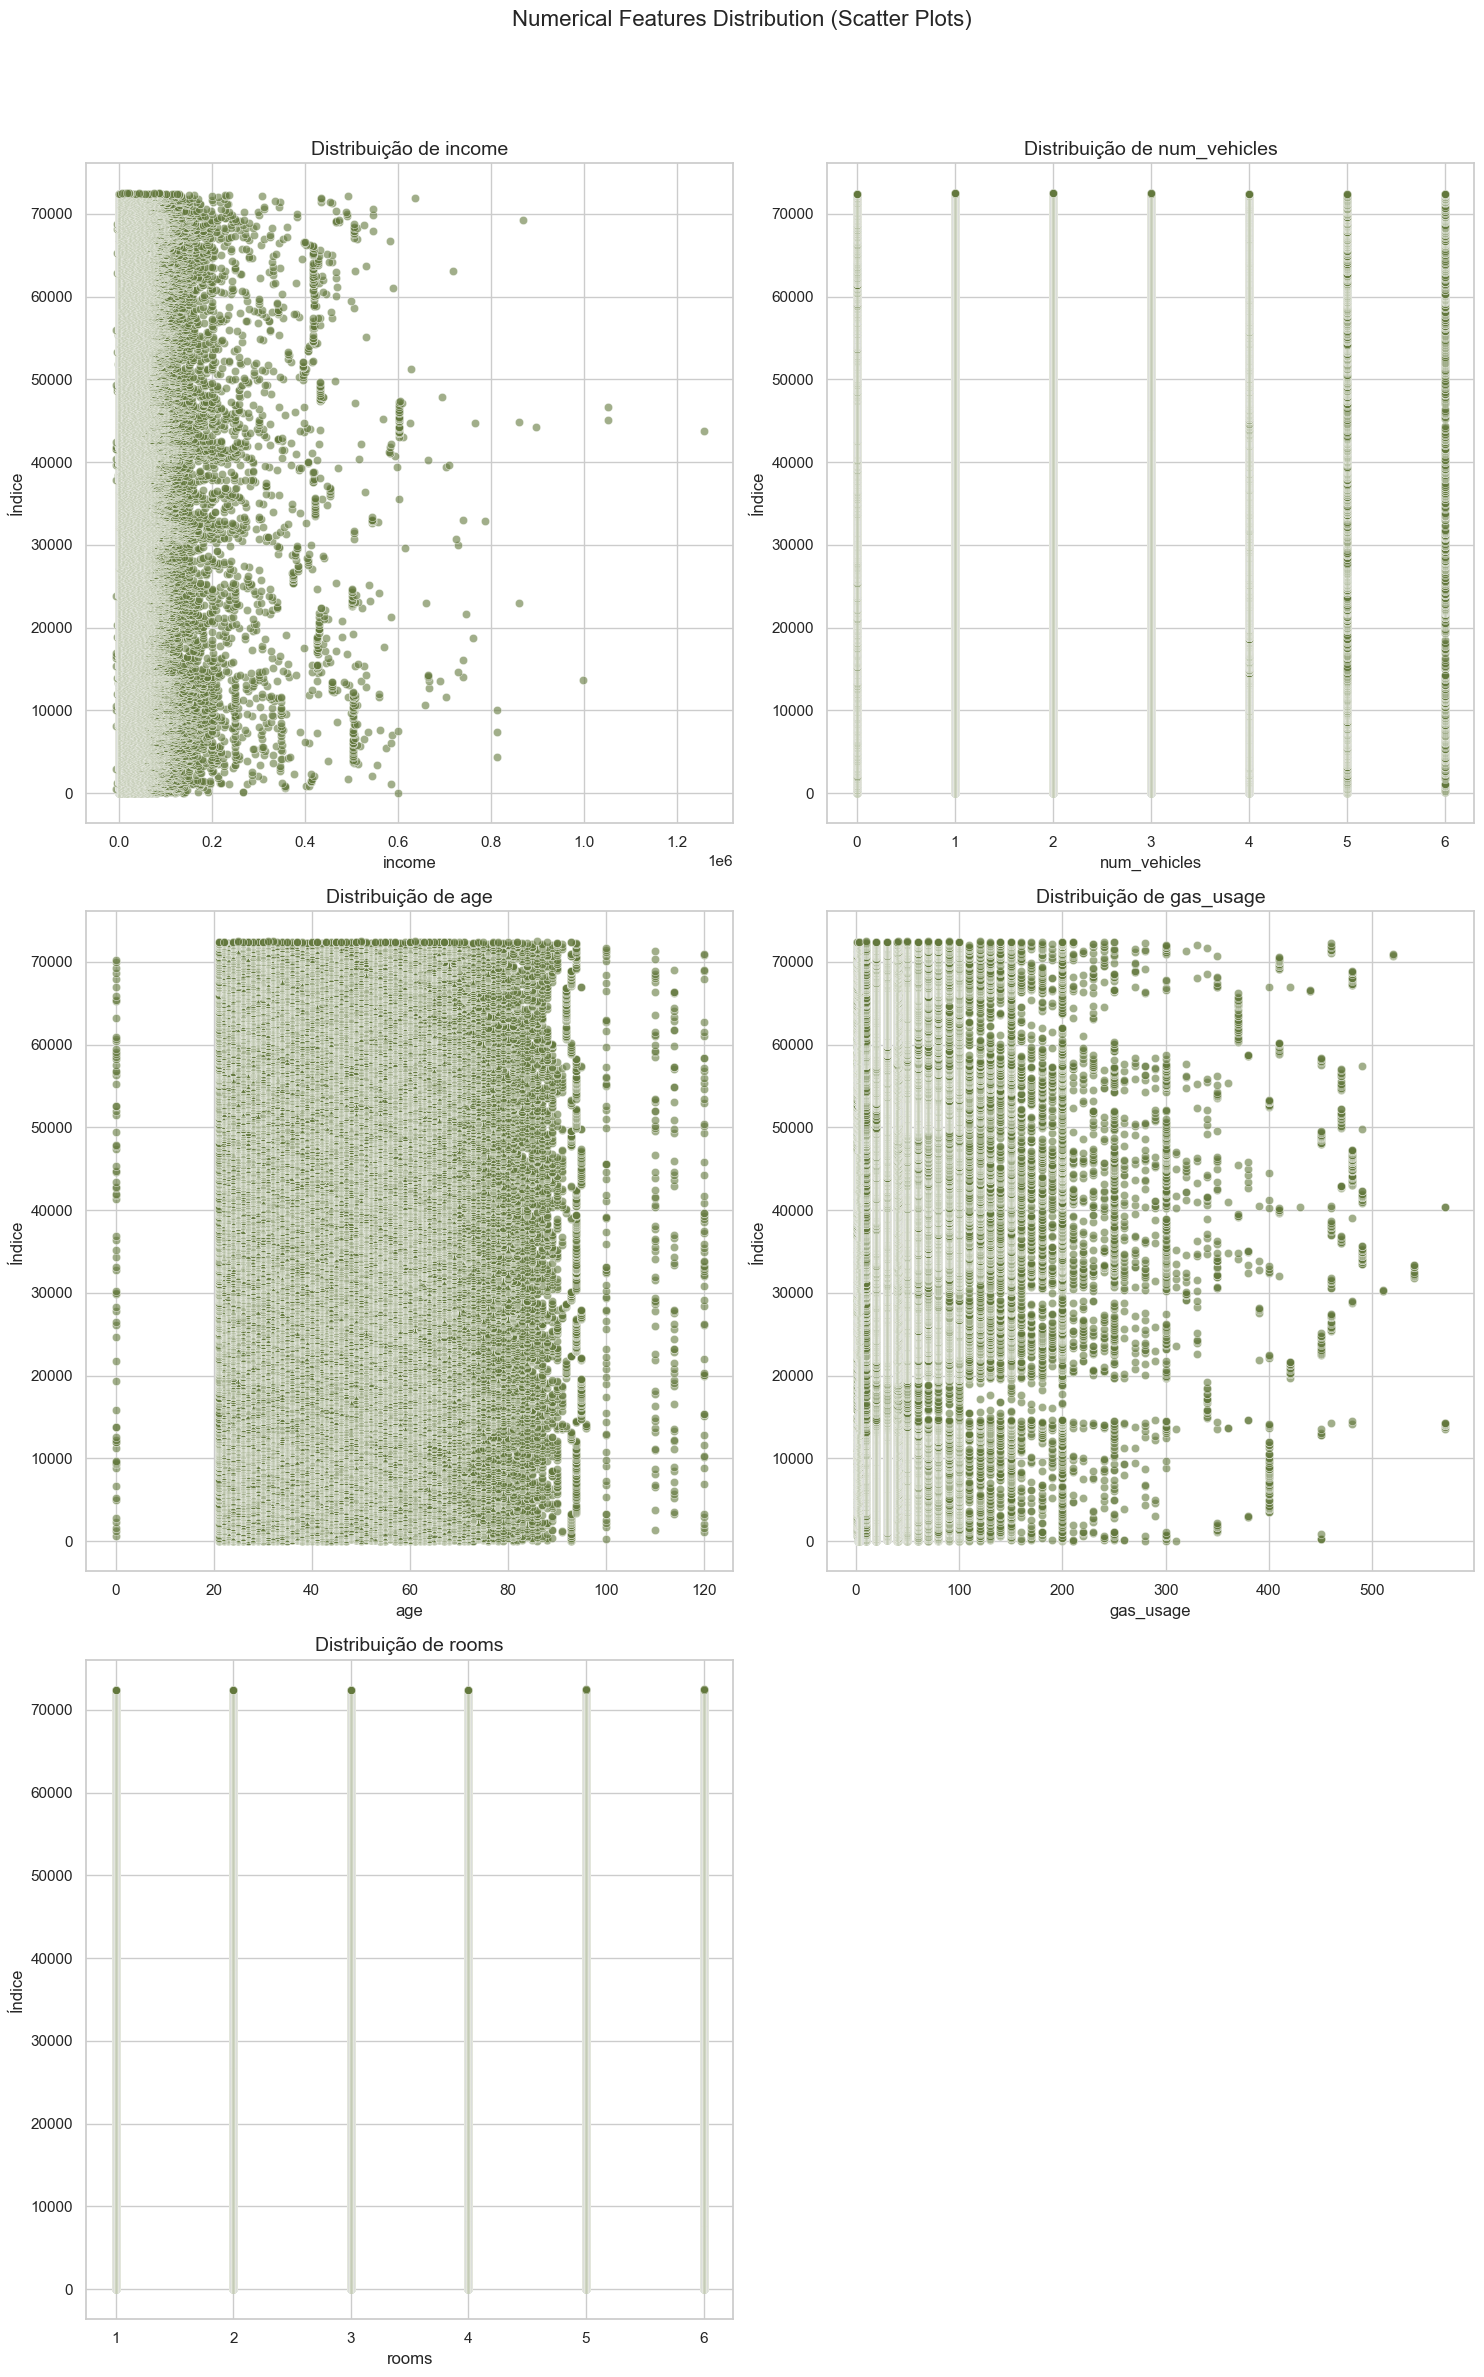

In [62]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 25))

color = custom_palette[0]

for i, feature in enumerate(numerical_features[:5], 1):
    plt.subplot(3, 2, i)  
    sns.scatterplot(data=df, x=feature, y=df.index, alpha=0.6, color=color)
    plt.title(f'Distribuição de {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Índice', fontsize=12)

plt.suptitle('Numerical Features Distribution (Scatter Plots)', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Outliers we need to handle

- **gas_usage**
- **age**
- **income**

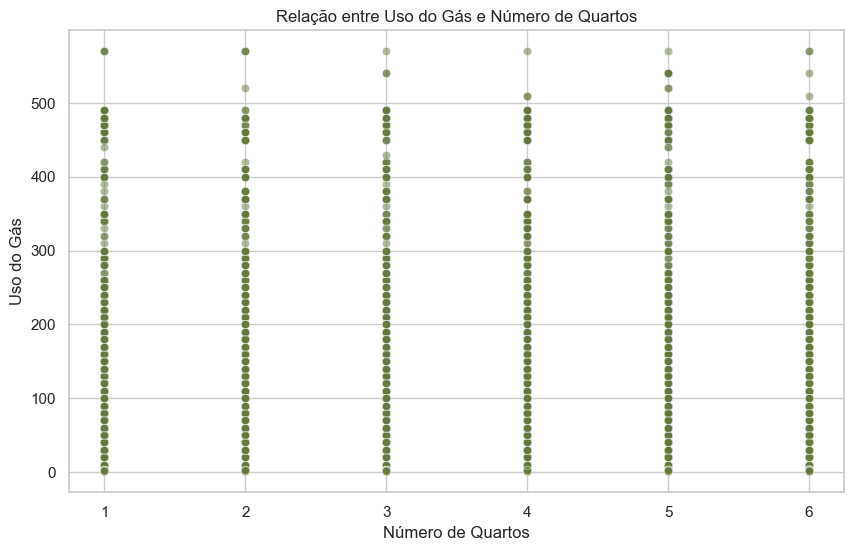

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='rooms', y='gas_usage', alpha=0.5,color=color)
plt.title('Relação entre Uso do Gás e Número de Quartos')
plt.xlabel('Número de Quartos')
plt.ylabel('Uso do Gás')
plt.show()

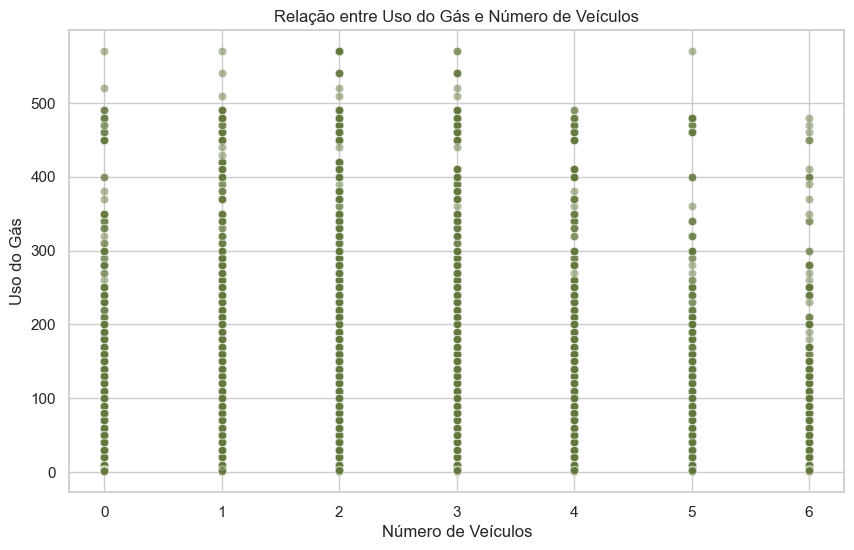

In [64]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_vehicles', y='gas_usage', alpha=0.5,color=color)
plt.title('Relação entre Uso do Gás e Número de Veículos')
plt.xlabel('Número de Veículos')
plt.ylabel('Uso do Gás')
plt.show()

# Outliers in gas_usage

In [65]:
Q1 = df['gas_usage'].quantile(0.25)
Q3 = df['gas_usage'].quantile(0.75)
IQR = Q3 - Q1

gas_lower_limit = Q1 - 1.5 * IQR
gas_upper_limit = Q3 + 1.5 * IQR

outliers = df[(df['gas_usage'] < gas_lower_limit) | (df['gas_usage'] > gas_upper_limit)]
outlier_count = outliers.shape[0]

print(f"Number of outliers: {outlier_count}")


Number of outliers: 5727


We noticed that there is a significant amount of outliers in this variable. Therefore, we should not simply remove them. However, by analyzing the boxplot of this variable, we observed that the outliers are most likely annual values. Thus, a good approach would be to divide these values by 12, so that all values are within the same unit of measure.


## gas_usage with log

In [66]:
df['gas_usage'] = np.log1p(df['gas_usage'])

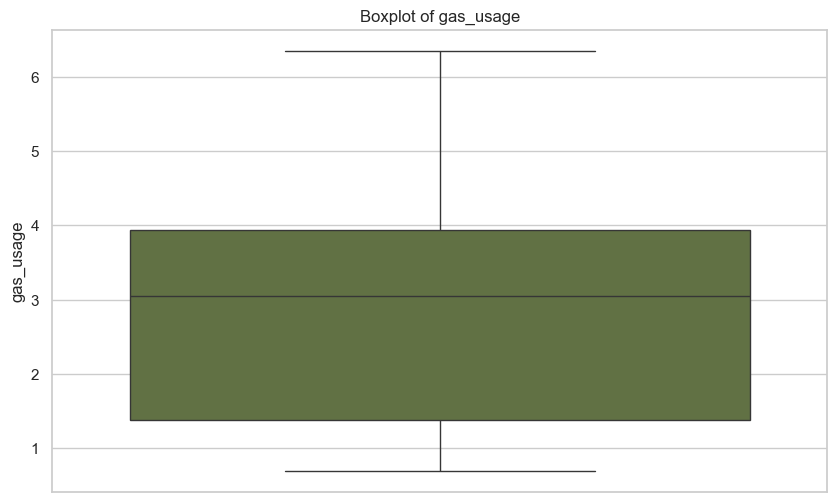

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='gas_usage', color=color)
plt.title('Boxplot of gas_usage')
plt.ylabel('gas_usage')
plt.show()

# Outliers in age

In [68]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

age_upper_limit = Q3 + 1.5 * IQR

print(f"Upper limit: {age_upper_limit}")

age_outliers = df[df['age'] > age_upper_limit]
age_outliers_count = age_outliers.shape[0]
print(f"Number of outliers: {age_outliers_count}")

Upper limit: 104.0
Number of outliers: 191


Since there are only 186 values, which is less than 0.5% of the dataset, we will remove these values.

In [69]:
#df = df[df['age'] <= age_upper_limit]
#df.loc[df['age'] > age_upper_limit, 'age'] = df['age'].mean()

# O PROFESSOR DISSE PARA ACEITARMOS...

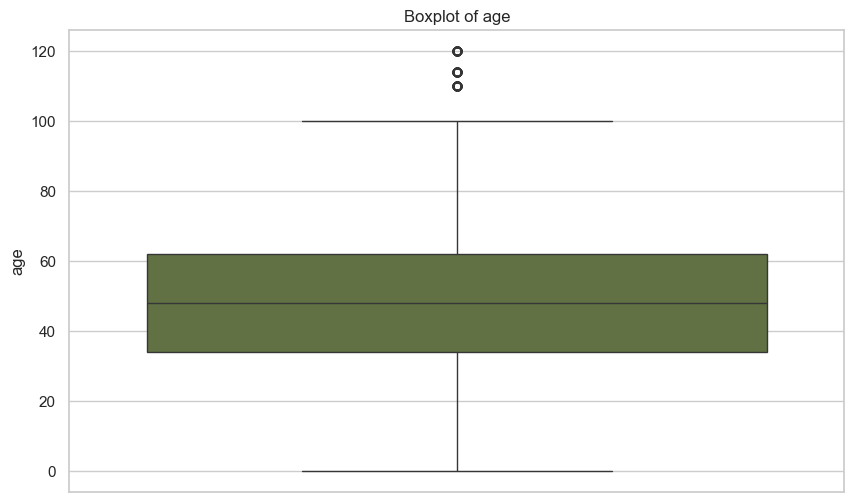

In [70]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='age',color=color)
plt.title('Boxplot of age')
plt.ylabel('age')
plt.show()

# Outliers in income

In [71]:
Q1 = df['income'].quantile(0.25)
Q3 = df['income'].quantile(0.75)
IQR = Q3 - Q1

income_upper_limit = Q3 + 1.5 * IQR

print(f"Upper limit: {income_upper_limit}")

income_outliers = df[df['income'] > income_upper_limit]
income_outliers_count = income_outliers.shape[0]
print(f"Number of outliers: {income_outliers_count}")

Upper limit: 113950.0
Number of outliers: 4512


In [72]:
'''df.loc[df['income'] > income_upper_limit, 'income'] /= 12'''
df['income'] = np.log1p(df['income'])

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


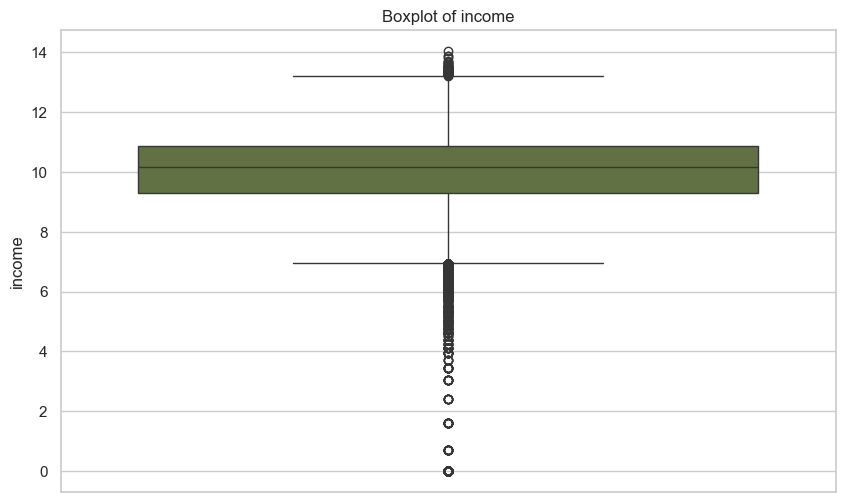

In [73]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='income',color=color)
plt.title('Boxplot of income')
plt.ylabel('income')
plt.show()

# Add columns for additional predictive power

In [74]:
df['age_group'] = pd.cut(df['age'], bins=[-1, 18, 35, 55, 75, 100, 145], labels=[0, 1, 2, 3, 4, 5])

df['income_per_vehicle'] = df['income'] / (df['num_vehicles'] + 1)  # Avoid division by zero

df['income_age_interaction'] = df['income'] * df['age']

#  Label encoding and binarization

In [75]:
df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b,age_group,income_per_vehicle,income_age_interaction
0,Male,True,9.998843,Never married,True,Homeowner free and clear,0.0,24,Alabama,5.351858,3,F,1,9.998843,239.972236
1,Female,Not in Workforce,10.051951,Divorced/Separated,True,Rented,0.0,82,Alabama,1.386294,6,T,4,10.051951,824.259954
2,Female,True,9.952325,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,3.713572,3,F,1,3.317442,308.522085
3,Female,Not in Workforce,10.539297,Widowed,True,Homeowner free and clear,1.0,93,Alabama,4.795791,2,F,4,5.269648,980.154611
4,Male,True,10.571343,Divorced/Separated,True,Rented,2.0,67,Alabama,1.386294,2,F,3,3.523781,708.279952


In [76]:
sex_mapping = {'Female': 0, 'Male': 1}
is_employed_mapping = {False: 0, True: 1, 'Not in Workforce': 2}
marital_status_mapping = {'Divorced/Separated': 0, 'Married': 1, 'Never married': 2, 'Widowed': 3}
housing_type_mapping = {'Homeowner free and clear': 0, 'Homeowner with mortgage/loan': 1, 'Occupied with no rent': 2, 'Rented': 3, 'Unknown': 4}
recent_move_b_mapping = {'F': 0, 'T': 1, 'Unknown': 2}
health_ins_mapping = {False: 0, True: 1, 'Not in Workforce': 2}

df['sex'] = df['sex'].map(sex_mapping)
df['is_employed'] = df['is_employed'].map(is_employed_mapping)
df['marital_status'] = df['marital_status'].map(marital_status_mapping)
df['housing_type'] = df['housing_type'].map(housing_type_mapping)
df['recent_move_b'] = df['recent_move_b'].map(recent_move_b_mapping)
df['health_ins'] = df['health_ins'].map(health_ins_mapping)

state_of_res_le = LabelEncoder()
age_group_le = LabelEncoder()
df['state_of_res'] = state_of_res_le.fit_transform(df['state_of_res'])
df['age_group'] = age_group_le.fit_transform(df['age_group'])

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b,age_group,income_per_vehicle,income_age_interaction
0,1,1,9.998843,2,1,0,0.0,24,0,5.351858,3,0,1,9.998843,239.972236
1,0,2,10.051951,0,1,3,0.0,82,0,1.386294,6,1,4,10.051951,824.259954
2,0,1,9.952325,2,1,1,2.0,31,0,3.713572,3,0,1,3.317442,308.522085
3,0,2,10.539297,3,1,0,1.0,93,0,4.795791,2,0,4,5.269648,980.154611
4,1,1,10.571343,0,1,3,2.0,67,0,1.386294,2,0,3,3.523781,708.279952


# Smote / Oversampling

Here we have a problem, that there is a big difference between "True" and "False".

In [77]:
print(df['health_ins'].value_counts())

health_ins
1    65553
0     6905
Name: count, dtype: int64


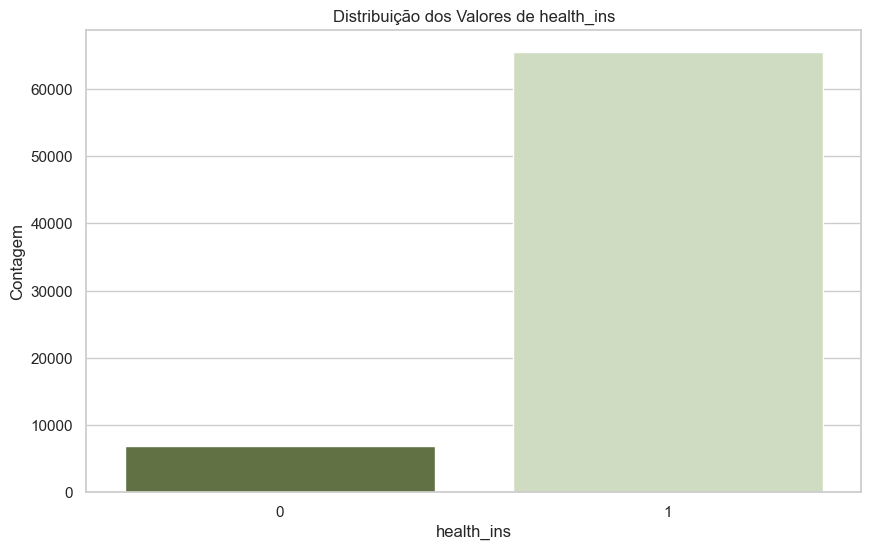

In [78]:
plt.figure(figsize=(10, 6))
sns.countplot(x='health_ins', data=df, hue='health_ins', palette=custom_palette, legend=False)
plt.title('Distribuição dos Valores de health_ins')
plt.xlabel('health_ins')
plt.ylabel('Contagem')
plt.show()

## Smote

In [79]:
smt = SMOTE(random_state=5)
X = df.drop('health_ins', axis = 1)
y = df['health_ins']
X_smote, y_smote = smt.fit_resample(X, y)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_25828/2700975266.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='health_ins', data=df_smote, palette=custom_palette, legend=False)


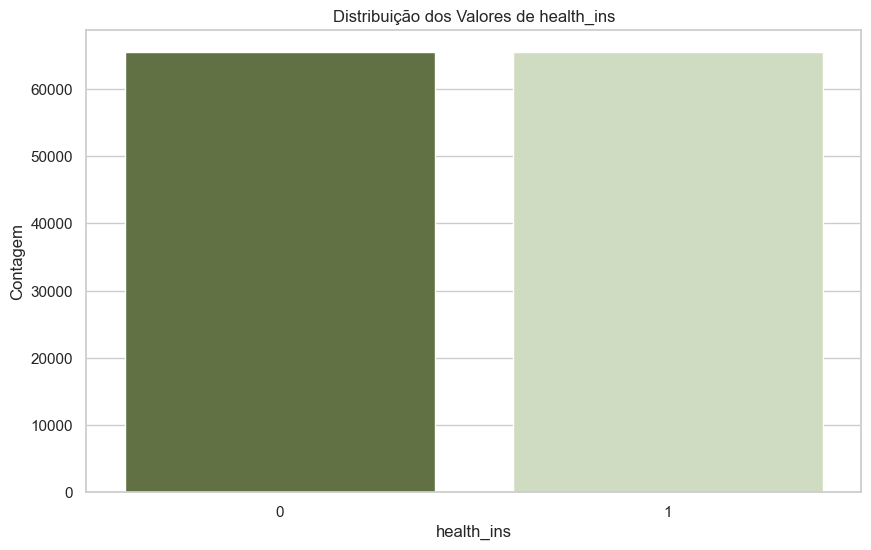

In [ ]:
df_smote = pd.concat([X_smote, y_smote], axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x='health_ins', data=df_smote, palette=custom_palette, legend=False)
plt.title('Distribuição dos Valores de health_ins')
plt.xlabel('health_ins')
plt.ylabel('Contagem')
plt.show()

In [ ]:
X = df.drop(columns=['health_ins'])
y = df['health_ins']
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1)

# Models

In [ ]:
default_results = {}

## KNN

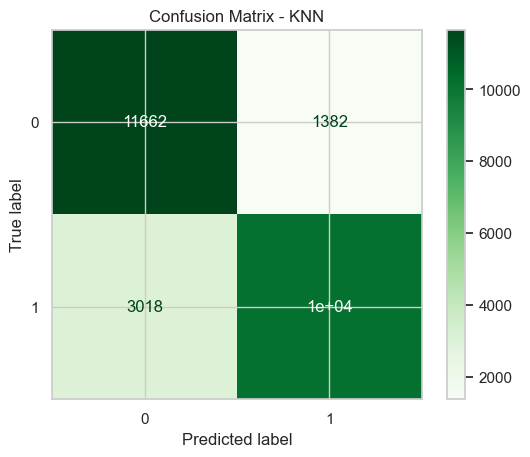

              precision    recall  f1-score   support

           0       0.79      0.89      0.84     13044
           1       0.88      0.77      0.82     13178

    accuracy                           0.83     26222
   macro avg       0.84      0.83      0.83     26222
weighted avg       0.84      0.83      0.83     26222



In [ ]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(training_inputs, training_classes)
knn_predictions = knn_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, knn_predictions, average='weighted')
accuracy = knn_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier.predict_proba(testing_inputs)[:, 1])

default_results['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, knn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - KNN')
plt.show()

print(classification_report(testing_classes, knn_predictions))

## Decision Tree

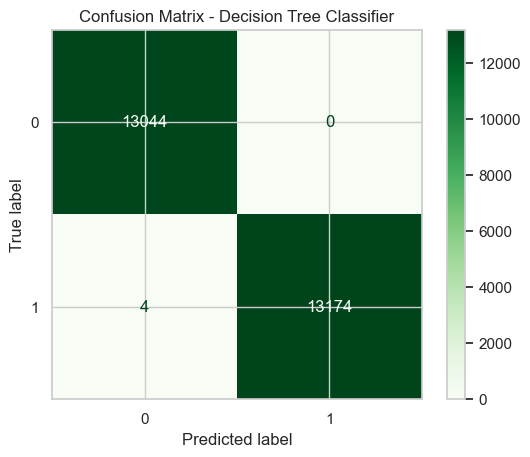

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13044
           1       1.00      1.00      1.00     13178

    accuracy                           1.00     26222
   macro avg       1.00      1.00      1.00     26222
weighted avg       1.00      1.00      1.00     26222



In [ ]:
#decision_tree_classifier = DecisionTreeClassifier(random_state=1)
decision_tree_classifier = DecisionTreeClassifier(random_state=1, class_weight='balanced')
decision_tree_classifier.fit(X_smote, y_smote)
tree_predictions = decision_tree_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, tree_predictions, average='weighted')
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier.predict_proba(testing_inputs)[:, 1])

default_results['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, tree_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

print(classification_report(testing_classes, tree_predictions))

## SVC

In [ ]:
'''svc_classifier = SVC(random_state=1)
svc_classifier.fit(X_smote, y_smote)
svc_predictions = svc_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, svc_predictions, average='weighted')
accuracy = svc_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, svc_predictions, average='weighted')
auc = roc_auc_score(testing_classes, svc_classifier.decision_function(testing_inputs))

default_results['SVC'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, svc_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - SVC')
plt.show()

print(classification_report(testing_classes, svc_predictions))''' 

"svc_classifier = SVC(random_state=1)\nsvc_classifier.fit(X_smote, y_smote)\nsvc_predictions = svc_classifier.predict(testing_inputs)\n\nf1 = f1_score(testing_classes, svc_predictions, average='weighted')\naccuracy = svc_classifier.score(testing_inputs, testing_classes)\nrecall = recall_score(testing_classes, svc_predictions, average='weighted')\nauc = roc_auc_score(testing_classes, svc_classifier.decision_function(testing_inputs))\n\ndefault_results['SVC'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}\n\ncm = confusion_matrix(testing_classes, svc_predictions)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm)\ndisp.plot(cmap=plt.cm.Greens)\nplt.title('Confusion Matrix - SVC')\nplt.show()\n\nprint(classification_report(testing_classes, svc_predictions))"

## Naive Bayes

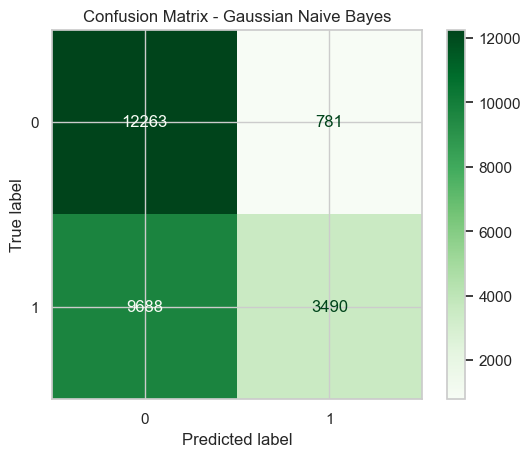

              precision    recall  f1-score   support

           0       0.56      0.94      0.70     13044
           1       0.82      0.26      0.40     13178

    accuracy                           0.60     26222
   macro avg       0.69      0.60      0.55     26222
weighted avg       0.69      0.60      0.55     26222



In [ ]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_smote, y_smote)
gnb_predictions = gnb_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, gnb_predictions, average='weighted')
accuracy = gnb_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, gnb_predictions, average='weighted')
auc = roc_auc_score(testing_classes, gnb_classifier.predict_proba(testing_inputs)[:, 1])

default_results['Gaussian Naive Bayes'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, gnb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

print(classification_report(testing_classes, gnb_predictions))

## Neural Networks

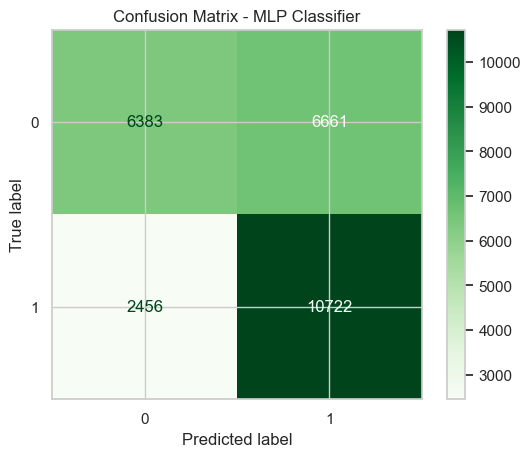

              precision    recall  f1-score   support

           0       0.72      0.49      0.58     13044
           1       0.62      0.81      0.70     13178

    accuracy                           0.65     26222
   macro avg       0.67      0.65      0.64     26222
weighted avg       0.67      0.65      0.64     26222



In [ ]:
mlp_classifier = MLPClassifier(random_state=1, max_iter=1000)
mlp_classifier.fit(X_smote, y_smote)
mlp_predictions = mlp_classifier.predict(testing_inputs)

f1 = f1_score(testing_classes, mlp_predictions, average='weighted')
accuracy = mlp_classifier.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, mlp_predictions, average='weighted')
auc = roc_auc_score(testing_classes, mlp_classifier.predict_proba(testing_inputs)[:, 1])

default_results['MLP'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, mlp_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - MLP Classifier')
plt.show()

print(classification_report(testing_classes, mlp_predictions))

## Smote results

In [ ]:
default_results = pd.DataFrame(default_results).T
default_results = default_results.sort_values(by='f1', ascending=False)
default_results

,f1,accuracy,recall,auc
Decision Tree,0.999847,0.999847,0.999847,1.000000
KNN,0.831600,0.832202,0.832202,0.907161
MLP,0.642829,0.652315,0.652315,0.679656
Gaussian Naive Bayes,0.549664,0.600755,0.600755,0.669039


## Oversampling

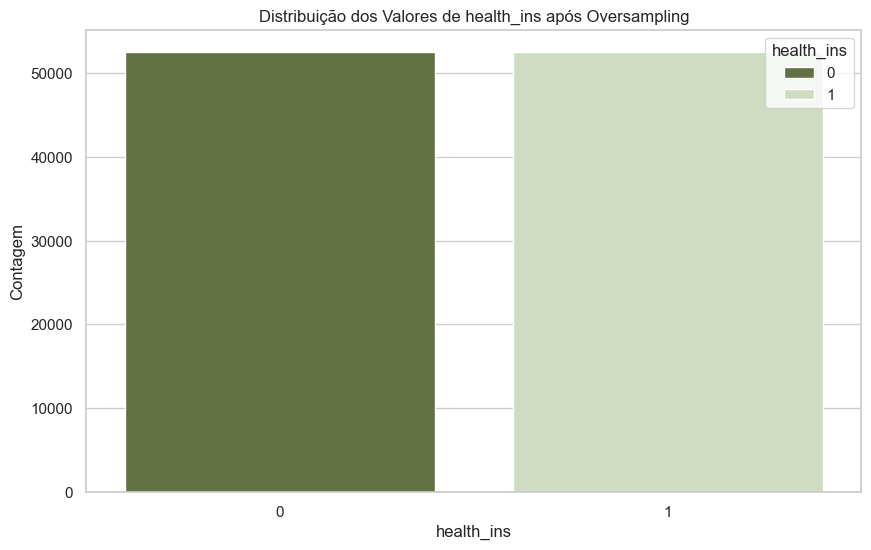

In [ ]:
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(training_inputs, training_classes)
df_over = pd.concat([X_over, y_over], axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x=y_over, palette=custom_palette, hue=y_over)
plt.title('Distribuição dos Valores de health_ins após Oversampling')
plt.xlabel('health_ins')
plt.ylabel('Contagem')
plt.show()

# Models

In [ ]:
default_results_over = {}

## KNN

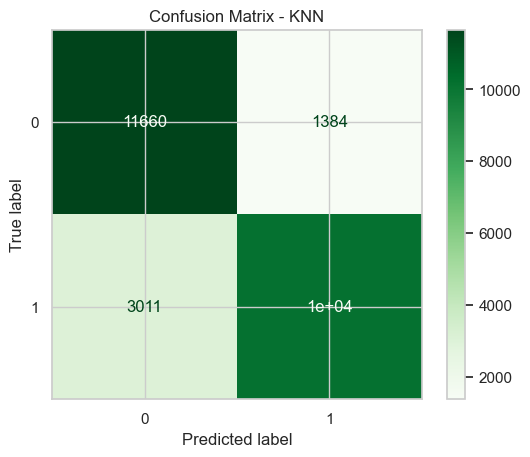

              precision    recall  f1-score   support

           0       0.79      0.89      0.84     13044
           1       0.88      0.77      0.82     13178

    accuracy                           0.83     26222
   macro avg       0.84      0.83      0.83     26222
weighted avg       0.84      0.83      0.83     26222



In [ ]:
knn_classifier_over = KNeighborsClassifier()
knn_classifier_over.fit(X_over, y_over)
knn_predictions_over = knn_classifier_over.predict(testing_inputs)

f1_over = f1_score(testing_classes, knn_predictions_over, average='weighted')
accuracy = knn_classifier_over.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, knn_predictions_over, average='weighted')
auc = roc_auc_score(testing_classes, knn_classifier_over.predict_proba(testing_inputs)[:, 1])

default_results_over['KNN'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, knn_predictions_over)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - KNN')
plt.show()

print(classification_report(testing_classes, knn_predictions_over))

## Decision Tree

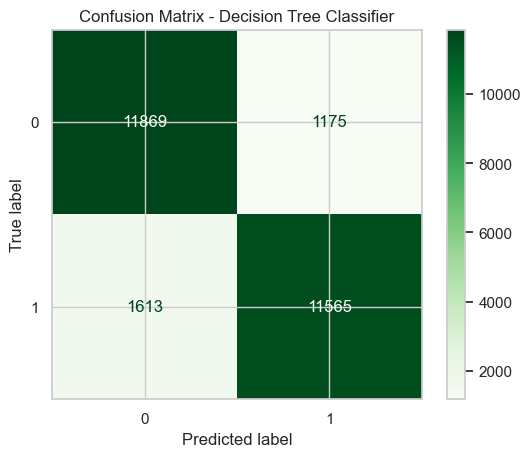

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     13044
           1       0.91      0.88      0.89     13178

    accuracy                           0.89     26222
   macro avg       0.89      0.89      0.89     26222
weighted avg       0.89      0.89      0.89     26222



In [ ]:
decision_tree_classifier_over = DecisionTreeClassifier(random_state=1)
decision_tree_classifier_over.fit(X_over, y_over)
tree_predictions_over = decision_tree_classifier_over.predict(testing_inputs)

f1 = f1_score(testing_classes, tree_predictions_over, average='weighted')
accuracy = decision_tree_classifier_over.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, tree_predictions_over, average='weighted')
auc = roc_auc_score(testing_classes, decision_tree_classifier_over.predict_proba(testing_inputs)[:, 1])

default_results_over['Decision Tree'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, tree_predictions_over)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

print(classification_report(testing_classes, tree_predictions_over))

## SVC

In [ ]:
'''svc_classifier_over = SVC(random_state=1)
svc_classifier_over.fit(X_over, y_over)
svc_predictions_over = svc_classifier_over.predict(testing_inputs_over)

f1 = f1_score(testing_classes_over, svc_predictions_over, average='weighted')
accuracy = svc_classifier_over.score(testing_inputs_over, testing_classes_over)
recall = recall_score(testing_classes_over, svc_predictions_over, average='weighted')
auc = roc_auc_score(testing_classes_over, svc_classifier_over.decision_function(testing_inputs_over))

default_results['SVC'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes_over, svc_predictions_over)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - SVC')
plt.show()

print(classification_report(testing_classes_over, svc_predictions_over))''' 

"svc_classifier_over = SVC(random_state=1)\nsvc_classifier_over.fit(X_over, y_over)\nsvc_predictions_over = svc_classifier_over.predict(testing_inputs_over)\n\nf1 = f1_score(testing_classes_over, svc_predictions_over, average='weighted')\naccuracy = svc_classifier_over.score(testing_inputs_over, testing_classes_over)\nrecall = recall_score(testing_classes_over, svc_predictions_over, average='weighted')\nauc = roc_auc_score(testing_classes_over, svc_classifier_over.decision_function(testing_inputs_over))\n\ndefault_results['SVC'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}\n\ncm = confusion_matrix(testing_classes_over, svc_predictions_over)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm)\ndisp.plot(cmap=plt.cm.Greens)\nplt.title('Confusion Matrix - SVC')\nplt.show()\n\nprint(classification_report(testing_classes_over, svc_predictions_over))"

## Naive Bayes

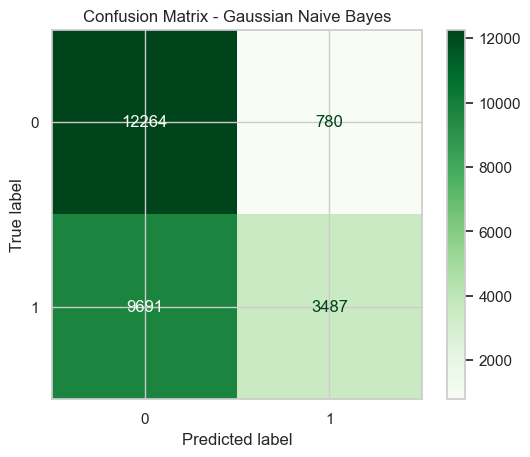

              precision    recall  f1-score   support

           0       0.56      0.94      0.70     13044
           1       0.82      0.26      0.40     13178

    accuracy                           0.60     26222
   macro avg       0.69      0.60      0.55     26222
weighted avg       0.69      0.60      0.55     26222



In [ ]:
gnb_classifier_over = GaussianNB()
gnb_classifier_over.fit(X_over, y_over)
gnb_predictions_over = gnb_classifier_over.predict(testing_inputs)

f1 = f1_score(testing_classes, gnb_predictions_over, average='weighted')
accuracy = gnb_classifier_over.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, gnb_predictions_over, average='weighted')
auc = roc_auc_score(testing_classes, gnb_classifier_over.predict_proba(testing_inputs)[:, 1])

default_results_over['Gaussian Naive Bayes'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, gnb_predictions_over)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

print(classification_report(testing_classes, gnb_predictions_over))

## Neural Networks

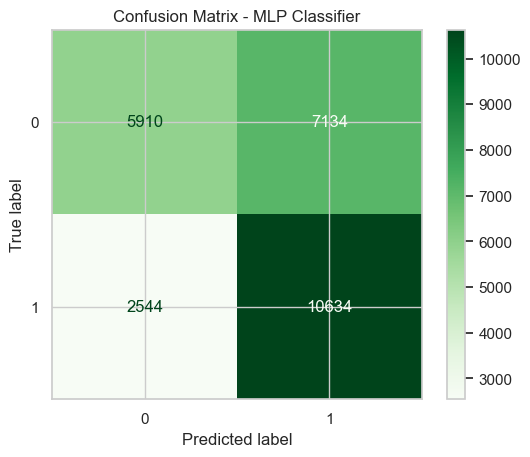

              precision    recall  f1-score   support

           0       0.70      0.45      0.55     13044
           1       0.60      0.81      0.69     13178

    accuracy                           0.63     26222
   macro avg       0.65      0.63      0.62     26222
weighted avg       0.65      0.63      0.62     26222



In [ ]:
mlp_classifier_over = MLPClassifier(random_state=1, max_iter=1000)
mlp_classifier_over.fit(X_over, y_over)
mlp_predictions_over = mlp_classifier_over.predict(testing_inputs)

f1 = f1_score(testing_classes, mlp_predictions_over, average='weighted')
accuracy = mlp_classifier_over.score(testing_inputs, testing_classes)
recall = recall_score(testing_classes, mlp_predictions_over, average='weighted')
auc = roc_auc_score(testing_classes, mlp_classifier_over.predict_proba(testing_inputs)[:, 1])

default_results_over['MLP'] = {'f1': f1, 'accuracy': accuracy, 'recall': recall, 'auc': auc}

cm = confusion_matrix(testing_classes, mlp_predictions_over)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - MLP Classifier')
plt.show()

print(classification_report(testing_classes, mlp_predictions_over))

## Oversampling Results

In [ ]:
default_results_over = pd.DataFrame(default_results_over).T
default_results_over = default_results_over.sort_values(by='f1', ascending=False)
default_results_over

,f1,accuracy,recall,auc
Decision Tree,0.893656,0.893677,0.893677,0.893785
KNN,0.642829,0.832393,0.832393,0.907199
MLP,0.618891,0.630921,0.630921,0.636076
Gaussian Naive Bayes,0.549526,0.600679,0.600679,0.668920


# Some Tests

## Better Decision Tree

In [ ]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

decision_tree = DecisionTreeClassifier(random_state=1)

#### With Smote

In [ ]:
grid_search = GridSearchCV(estimator=decision_tree,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='f1_weighted')

grid_search.fit(X_smote, y_smote)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_decision_tree = grid_search.best_estimator_

tree_predictions = best_decision_tree.predict(testing_inputs)
f1 = f1_score(testing_classes, tree_predictions, average='weighted')
print(f"Improved Decision Tree F1 Score: {f1}")

Best parameters found:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Improved Decision Tree F1 Score: 0.7499463124657952


#### With Oversampling

In [ ]:
grid_search_over = GridSearchCV(estimator=decision_tree, 
                                param_grid=param_grid, 
                                cv=skf, 
                                scoring='f1_weighted', 
                                n_jobs=-1)


grid_search_over.fit(X_over, y_over)

best_params_over = grid_search_over.best_params_
print("Best parameters found for oversampling: ", best_params_over)

best_decision_tree_over = grid_search_over.best_estimator_

tree_predictions_over = best_decision_tree_over.predict(testing_inputs)
f1_over = f1_score(testing_classes, tree_predictions_over, average='weighted')
print(f"Improved Decision Tree F1 Score with Oversampling: {f1_over}")

Best parameters found for oversampling:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Improved Decision Tree F1 Score with Oversampling: 0.8941486465279145


## Better KNN

In [ ]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

training_inputs_knnB, testing_inputs_knnB, training_classes_knnB, testing_classes_knnB = train_test_split(X_normalized, y, test_size=0.2, random_state=1)

param_grid = {
    'n_neighbors': np.arange(1, 31, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}
knn = KNeighborsClassifier()

#### Normalized

In [ ]:
'''randomized_search = RandomizedSearchCV(
    knn,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=1
)
randomized_search.fit(training_inputs_knnB, training_classes_knnB)

print("Best parameters:", randomized_search.best_params_)
best_knn = randomized_search.best_estimator_

# Evaluate on test data
knn_predictions = best_knn.predict(testing_inputs_knnB)
f1 = f1_score(testing_classes_knnB, knn_predictions, average='weighted')
print(f"Improved KNN F1 Score: {f1}")'''

'randomized_search = RandomizedSearchCV(\n    knn,\n    param_distributions=param_grid,\n    n_iter=20,\n    cv=5,\n    scoring=\'f1_weighted\',\n    n_jobs=-1,\n    random_state=1\n)\nrandomized_search.fit(training_inputs_knnB, training_classes_knnB)\n\nprint("Best parameters:", randomized_search.best_params_)\nbest_knn = randomized_search.best_estimator_\n\n# Evaluate on test data\nknn_predictions = best_knn.predict(testing_inputs_knnB)\nf1 = f1_score(testing_classes_knnB, knn_predictions, average=\'weighted\')\nprint(f"Improved KNN F1 Score: {f1}")'

In [ ]:
'''
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=1)),
    ('knn', KNeighborsClassifier())
])
param_grid = {
    'knn__n_neighbors': np.arange(1, 51, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]  # Relevante apenas para 'minkowski'
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1
)

X = df.drop('health_ins', axis=1)
y = df['health_ins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, stratify=y, random_state=1)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_'''

'from imblearn.pipeline import Pipeline\nfrom sklearn.neighbors import KNeighborsClassifier\n\npipeline = Pipeline([\n    (\'scaler\', MinMaxScaler()),\n    (\'smote\', SMOTE(random_state=1)),\n    (\'knn\', KNeighborsClassifier())\n])\nparam_grid = {\n    \'knn__n_neighbors\': np.arange(1, 51, 2),\n    \'knn__weights\': [\'uniform\', \'distance\'],\n    \'knn__metric\': [\'euclidean\', \'manhattan\', \'minkowski\'],\n    \'knn__p\': [1, 2]  # Relevante apenas para \'minkowski\'\n}\n\ngrid_search = GridSearchCV(\n    pipeline,\n    param_grid=param_grid,\n    cv=skf,\n    scoring=\'f1_weighted\',\n    n_jobs=-1\n)\n\nX = df.drop(\'health_ins\', axis=1)\ny = df[\'health_ins\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, stratify=y, random_state=1)\n\ngrid_search.fit(X_train, y_train)\nprint("Best parameters:", grid_search.best_params_)\nbest_knn = grid_search.best_estimator_'

## Random Forest

In [ ]:
'''rf = RandomForestClassifier(random_state=1)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=skf, scoring='f1_weighted', n_jobs=-1)
grid_search_rf.fit(X_smote, y_smote)'''

"rf = RandomForestClassifier(random_state=1)\nparam_grid_rf = {\n    'n_estimators': [100, 200],\n    'max_depth': [None, 10, 20],\n    'min_samples_split': [2, 5],\n    'min_samples_leaf': [1, 2],\n    'criterion': ['gini', 'entropy']\n}\ngrid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=skf, scoring='f1_weighted', n_jobs=-1)\ngrid_search_rf.fit(X_smote, y_smote)"

## Remove Features?

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_25828/2119736067.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(X.shape[1]), y=importances[indices], align='center',palette=custom_palette)
/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_25828/2119736067.py:7: UserWarning: 
The palette list has fewer values (2) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=range(X.shape[1]), y=importances[indices], align='center',palette=custom_palette)


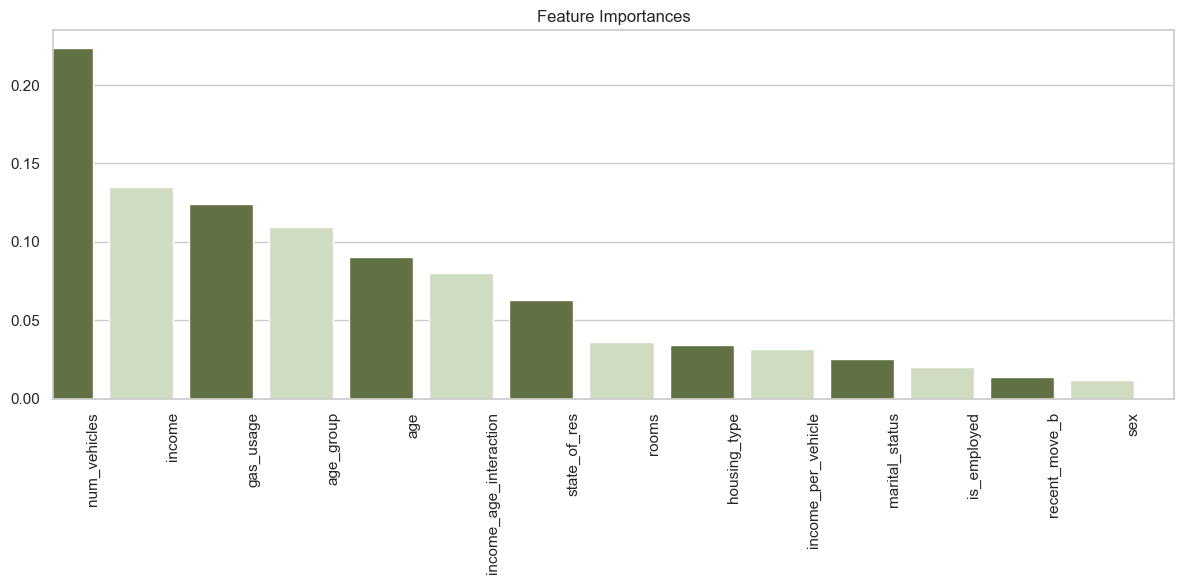

In [ ]:
importances = best_decision_tree_over.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
sns.barplot(x=range(X.shape[1]), y=importances[indices], align='center',palette=custom_palette)
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# Final File

In [ ]:
df_test = pd.read_csv('../HealthInsurancePredictor/data/customer_test_masked.csv')

custid = df_test['custid']

# Pré-processamentos
df_test = df_test.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

# Tratar valores ausentes
df_test['is_employed'] = df_test['is_employed'].fillna('Not in Workforce')

# se metermos a média
df_test['housing_type'] = df_test['housing_type'].fillna(df_test['housing_type'].mode()[0])
df_test['num_vehicles'] = df_test['num_vehicles'].fillna(df_test['num_vehicles'].mean())
df_test['recent_move_b'] = df_test['recent_move_b'].fillna(df_test['recent_move_b'].mode()[0])
df_test['gas_usage'] = df_test['gas_usage'].fillna(df['gas_usage'].mean())
df_test['gas_usage'] = df_test['gas_usage'].replace('001', 0)
df_test['gas_usage'] = df_test['gas_usage'].replace('002', 0)
df_test['gas_usage'] = df_test['gas_usage'].replace('003', 0)
df_test['age'] = df_test['age'].fillna(df['age'].mean())

# Tratar outliers
df_test['gas_usage'] = np.log1p(df_test['gas_usage'])
df_test['income'] = np.log1p(df_test['income'])

# Adicionar colunas
df_test['age_group'] = pd.cut(df_test['age'], bins=[-1, 18, 35, 55, 75, 100, 145], labels=[0, 1, 2, 3, 4, 5])
df_test['income_per_vehicle'] = df_test['income'] / (df_test['num_vehicles'] + 1)  # Avoid division by zero
df_test['income_age_interaction'] = df_test['income'] * df_test['age']

# Encoding
sex_mapping = {'Female': 0, 'Male': 1}
is_employed_mapping = {False: 0, True: 1, 'Not in Workforce': 2}
marital_status_mapping = {'Divorced/Separated': 0, 'Married': 1, 'Never married': 2, 'Widowed': 3}
housing_type_mapping = {'Homeowner free and clear': 0, 'Homeowner with mortgage/loan': 1, 
                        'Occupied with no rent': 2, 'Rented': 3, 'Unknown': 4}
recent_move_b_mapping = {'F': 0, 'T': 1, 'Unknown': 2}

df_test['sex'] = df_test['sex'].map(sex_mapping)
df_test['is_employed'] = df_test['is_employed'].map(is_employed_mapping)
df_test['marital_status'] = df_test['marital_status'].map(marital_status_mapping)
df_test['housing_type'] = df_test['housing_type'].map(housing_type_mapping)
df_test['recent_move_b'] = df_test['recent_move_b'].map(recent_move_b_mapping)

# Label encode 'state_of_res'
state_of_res_le = LabelEncoder()
df_test['state_of_res'] = state_of_res_le.fit_transform(df_test['state_of_res'])

# Preparar os dados para a previsão
X_test_final = df_test.drop(columns=['health_ins'], errors='ignore')

# Previsões com o modelo treinado
predictions = decision_tree_classifier.predict(X_test_final)  # ou substitua por `knn_classifier.predict` ou `decision_tree_classifier.predict` conforme o modelo escolhido

# Arquivo
submission = pd.DataFrame({'custid': custid, 'health_ins': predictions})
submission.to_csv('submission.csv', index=False)

print("Arquivo 'submission.csv' gerado com sucesso!")


Arquivo 'submission.csv' gerado com sucesso!


/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_25828/2837733764.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.18532338308458' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df['age'] > age_upper_limit, 'age'] = df_test['age'].mean()
